In [ ]:
!pip install gymnasium
!pip install gymnasium[classic-control]
!pip install gymnasium[other]
!pip install IPython

In [2]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('videos/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video).decode('ascii')
    ipythondisplay.display(HTML(data='<video controls src="data:video/x-m4v;base64,{0}">'.format(encoded)))
  else:
    print("Could not find video")

In [14]:
class Agent:

    def __init__(self):
        self.cumulative_reward = 0

    def step(self, action_space, observation):
        pass

    def reward(self, immediate_reward):
        self.cumulative_reward += immediate_reward

    def reset(self):
        print("Cumulative reward for this round:", self.cumulative_reward)
        self.cumulative_reward = 0


def run_episode(agent: Agent, show_video=False):
    env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./videos")
    observation, info = env.reset()
    cumulative_reward = 0
    while True:
        action = agent.step(env.action_space, observation)
        observation, reward, terminated, truncated, info  = env.step(action)
        agent.reward(reward)
        if terminated or truncated:
            observation, info = env.reset()
            cumulative_reward += agent.cumulative_reward
            agent.reset()
            break
    if show_video: show_video()
    return cumulative_reward


In [15]:
import matplotlib.pyplot as plt

class RandomAgent(Agent):
    def step(self, action_space, observation):
        return action_space.sample()

episode_results = []
random_agent = RandomAgent()
for i in range(100):
    episode_results.append(run_episode(random_agent))




Cumulative reward for this round: 19.0
Cumulative reward for this round: 15.0
Cumulative reward for this round: 51.0
Cumulative reward for this round: 28.0
Cumulative reward for this round: 11.0
Cumulative reward for this round: 16.0
Cumulative reward for this round: 11.0
Cumulative reward for this round: 20.0
Cumulative reward for this round: 20.0
Cumulative reward for this round: 20.0
Cumulative reward for this round: 26.0
Cumulative reward for this round: 15.0
Cumulative reward for this round: 18.0
Cumulative reward for this round: 28.0
Cumulative reward for this round: 33.0
Cumulative reward for this round: 42.0
Cumulative reward for this round: 68.0
Cumulative reward for this round: 32.0
Cumulative reward for this round: 25.0
Cumulative reward for this round: 12.0
Cumulative reward for this round: 24.0
Cumulative reward for this round: 19.0
Cumulative reward for this round: 13.0
Cumulative reward for this round: 26.0
Cumulative reward for this round: 41.0
Cumulative reward for thi

[19.0, 15.0, 51.0, 28.0, 11.0, 16.0, 11.0, 20.0, 20.0, 20.0, 26.0, 15.0, 18.0, 28.0, 33.0, 42.0, 68.0, 32.0, 25.0, 12.0, 24.0, 19.0, 13.0, 26.0, 41.0, 17.0, 13.0, 12.0, 33.0, 50.0, 27.0, 15.0, 17.0, 53.0, 26.0, 21.0, 28.0, 15.0, 53.0, 37.0, 46.0, 53.0, 37.0, 13.0, 19.0, 19.0, 35.0, 15.0, 14.0, 47.0, 25.0, 20.0, 15.0, 33.0, 18.0, 15.0, 21.0, 14.0, 14.0, 18.0, 28.0, 11.0, 17.0, 14.0, 15.0, 24.0, 9.0, 33.0, 12.0, 15.0, 15.0, 14.0, 22.0, 17.0, 13.0, 24.0, 22.0, 27.0, 29.0, 21.0, 19.0, 10.0, 14.0, 16.0, 22.0, 10.0, 25.0, 13.0, 17.0, 15.0, 66.0, 14.0, 31.0, 9.0, 9.0, 34.0, 11.0, 23.0, 15.0, 15.0]


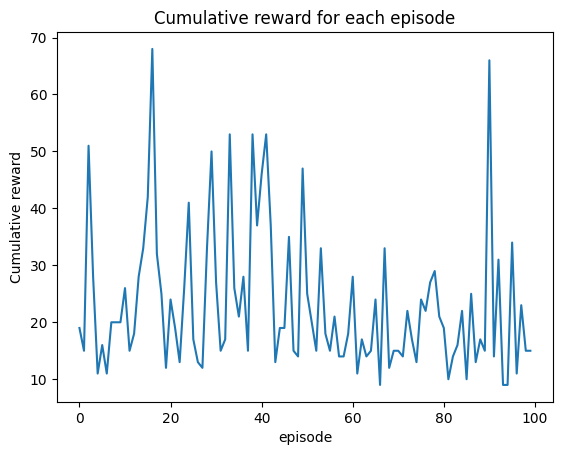

In [16]:
print(episode_results)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()